In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# URL del CSV en GitHub (modo raw)
BLOB_URL = "https://github.com/LeninGF/responsibleAI-dmiDetained/blob/main/data/mdi_detenidos_2024_limpio.csv"
RAW_URL = BLOB_URL.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")

# Carga
df = pd.read_csv(RAW_URL)

print("Shape:", df.shape)
display(df.head(3))
print("Columnas:", df.columns.tolist())

Shape: (40976, 8)


,tipo,estado_civil,edad,genero,tipo_lugar,codigo_provincia,nombre_provincia,presunta_infraccion
0,APREHENDIDO,SOLTERO/A,19,MASCULINO,ÁREA DE ACCESO PÚBLICO,2,BOLÍVAR,OTROS
1,DETENIDO,CASADO/A,40,MASCULINO,ÁREA PRIVADA,15,NAPO,OTROS
2,APREHENDIDO,SOLTERO/A,36,FEMENINO,OTROS,17,PICHINCHA,OTROS


Columnas: ['tipo', 'estado_civil', 'edad', 'genero', 'tipo_lugar', 'codigo_provincia', 'nombre_provincia', 'presunta_infraccion']


In [3]:
# Lista de columnas candidatas a objetivo (usa la primera que exista)
preferred_targets = ["tipo", "presunta_infraccion"]
TARGET_COL = next((c for c in preferred_targets if c in df.columns), None)

if TARGET_COL is None:
    raise ValueError(f"No se encontró ninguna de {preferred_targets} en el CSV. Revisa las columnas arriba.")

# Filtrar filas con target no nulo
df = df[~df[TARGET_COL].isna()].copy()

# Objetivo en string (clasificación)
y = df[TARGET_COL].astype(str)
X = df.drop(columns=[TARGET_COL])

print("Target seleccionado:", TARGET_COL)
print("Distribución de clases:")
display(y.value_counts().to_frame("conteo"))

Target seleccionado: tipo
Distribución de clases:


,conteo
tipo,
APREHENDIDO,31010
DETENIDO,9966


In [4]:
# Detectar columnas por tipo
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# Pipelines de preprocesamiento
num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols),
    ],
    remainder="drop"
)

Numéricas: ['edad', 'codigo_provincia']
Categóricas: ['estado_civil', 'genero', 'tipo_lugar', 'nombre_provincia', 'presunta_infraccion']


In [5]:
# Train/Test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# Pipeline completo: preprocesamiento + KNN
pipe = Pipeline([
    ("prep", preprocess),
    ("knn", KNeighborsClassifier())
])

# Grid de hiperparámetros
param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # Manhattan vs Euclidiana
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    scoring="f1_macro",
    verbose=1
)

grid.fit(X_train, y_train)

print("Target:", TARGET_COL)
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor F1_macro (CV):", round(grid.best_score_, 4))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Target: tipo
Mejores hiperparámetros: {'knn__n_neighbors': 15, 'knn__p': 2, 'knn__weights': 'uniform'}
Mejor F1_macro (CV): 0.8043


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.76476209 0.77918423 0.76379405        nan 0.77492458
 0.79365012 0.77394348        nan 0.77850539 0.79946939 0.77914394
        nan 0.78073838 0.80086101 0.78092048        nan 0.78215735
 0.80123643 0.78159783        nan 0.783721   0.80425806 0.78343244]
  warnings.warn(



=== Classification Report (test) ===
              precision    recall  f1-score   support

 APREHENDIDO     0.8789    0.9739    0.9240      6203
    DETENIDO     0.8776    0.5825    0.7002      1993

    accuracy                         0.8787      8196
   macro avg     0.8782    0.7782    0.8121      8196
weighted avg     0.8786    0.8787    0.8696      8196



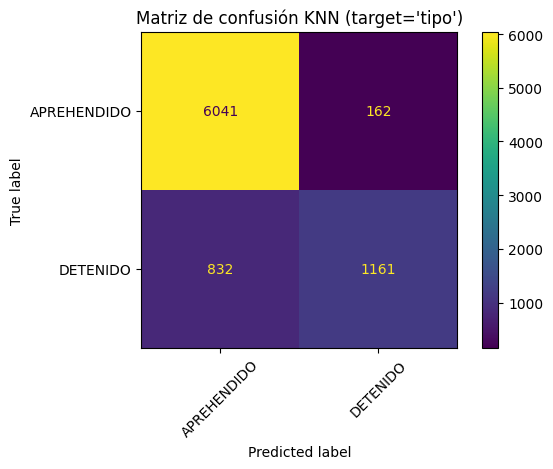

In [6]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
print("\n=== Classification Report (test) ===")
print(classification_report(y_test, y_pred, digits=4))

labels = np.unique(y)  # para mantener orden consistente
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.title(f"Matriz de confusión KNN (target='{TARGET_COL}')")
plt.tight_layout()
plt.show()

AHORA PARA HACERLO CON PRESUNTA INFRACCION COMO LABEL

In [7]:
TARGET_COL = "presunta_infraccion"

if TARGET_COL not in df.columns:
    raise ValueError(f"La columna '{TARGET_COL}' no existe en el CSV. Columnas: {df.columns.tolist()}")

# Filtrar filas con target no nulo
df = df[~df[TARGET_COL].isna()].copy()

# Separar X / y
y = df[TARGET_COL].astype(str)  # clasificación
X = df.drop(columns=[TARGET_COL])

print("Target seleccionado:", TARGET_COL)
print("Distribución de clases:")
display(y.value_counts().to_frame("conteo"))

Target seleccionado: presunta_infraccion
Distribución de clases:


,conteo
presunta_infraccion,
OTROS,21404
DELITOS CONTRA EL DERECHO A LA PROPIEDAD,7141
BOLETAS,6217
DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE SUSTANCIAS CATALOGADAS SUJETAS A FISCALIZACIÓN,6214


In [8]:
# Detectar columnas
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# Pipelines
num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols),
    ],
    remainder="drop"
)

Numéricas: ['edad', 'codigo_provincia']
Categóricas: ['tipo', 'estado_civil', 'genero', 'tipo_lugar', 'nombre_provincia']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

pipe = Pipeline([
    ("prep", preprocess),
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    scoring="f1_macro",
    verbose=1
)

grid.fit(X_train, y_train)

print("Target:", TARGET_COL)
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor F1_macro (CV):", round(grid.best_score_, 4))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Target: presunta_infraccion
Mejores hiperparámetros: {'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}
Mejor F1_macro (CV): 0.4675


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.44018665 0.44270632 0.43941159        nan 0.4552769
 0.46750718 0.45787923        nan 0.45644957 0.46501502 0.45555168
        nan 0.45757617 0.465115   0.45572153        nan 0.4573722
 0.46596805 0.45765013        nan 0.45609077 0.46232717 0.45735885]
  warnings.warn(



=== Classification Report (test) ===
                                                                                               precision    recall  f1-score   support

                                                                                      BOLETAS     0.6253    0.7621    0.6870      1244
                                                     DELITOS CONTRA EL DERECHO A LA PROPIEDAD     0.2831    0.2857    0.2844      1428
DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE SUSTANCIAS CATALOGADAS SUJETAS A FISCALIZACIÓN     0.2934    0.2204    0.2517      1243
                                                                                        OTROS     0.6423    0.6459    0.6441      4281

                                                                                     accuracy                         0.5362      8196
                                                                                    macro avg     0.4610    0.4785    0.4668      8196
               

/tmp/ipython-input-291748838.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


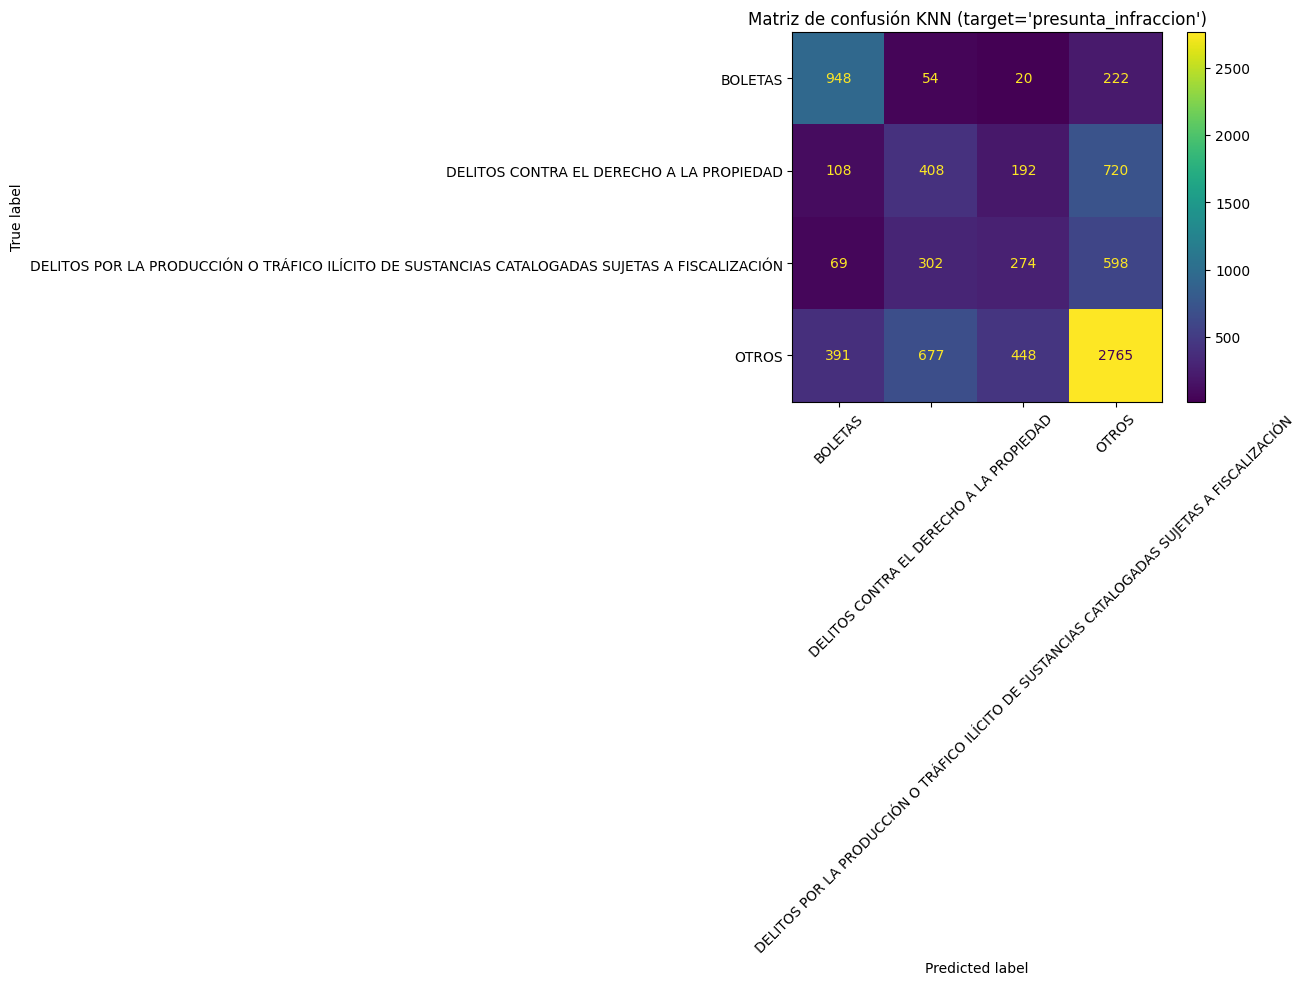

In [10]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== Classification Report (test) ===")
print(classification_report(y_test, y_pred, digits=4))

labels = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.title(f"Matriz de confusión KNN (target='{TARGET_COL}')")
plt.tight_layout()
plt.show()

Dataset sin limpiar

In [11]:
# URL del CSV en GitHub (modo raw)
BLOB_URL = "https://github.com/LeninGF/responsibleAI-dmiDetained/blob/main/data/mdi_detenidos_2024_biased.csv"
RAW_URL = BLOB_URL.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")

# Carga
df = pd.read_csv(RAW_URL)

print("Shape:", df.shape)
display(df.head(3))
print("Columnas:", df.columns.tolist())

Shape: (41510, 15)


,tipo,estado_civil,estatus_migratorio,edad,sexo,genero,nacionalidad,autoidentificacion_etnica,nivel_de_instruccion,movilizacion,tipo_arma,arma,tipo_lugar,nombre_provincia,presunta_infraccion
0,APREHENDIDO,SOLTERO/A,NO APLICA,19,HOMBRE,MASCULINO,ECUATORIANO,MESTIZO/A,TERCER NIVEL TÉCNICO-TECNOLÓGICO Y DE GRADO,A PIE,NINGUNA,NINGUNA,ÁREA DE ACCESO PÚBLICO,BOLÍVAR,OTROS
1,DETENIDO,CASADO/A,NO APLICA,40,HOMBRE,MASCULINO,ECUATORIANO,INDÍGENA,EDUCACIÓN GENERAL BÁSICA,A PIE,NINGUNA,NINGUNA,ÁREA PRIVADA,NAPO,OTROS
2,APREHENDIDO,SOLTERO/A,NO APLICA,36,HOMBRE,FEMENINO,ECUATORIANO,MESTIZO/A,NO APLICA,NO APLICA,NINGUNA,NINGUNA,ÁREAS DEDICADAS AL COMERCIO,PICHINCHA,OTROS


Columnas: ['tipo', 'estado_civil', 'estatus_migratorio', 'edad', 'sexo', 'genero', 'nacionalidad', 'autoidentificacion_etnica', 'nivel_de_instruccion', 'movilizacion', 'tipo_arma', 'arma', 'tipo_lugar', 'nombre_provincia', 'presunta_infraccion']


In [12]:
TARGET_COL = "presunta_infraccion"

if TARGET_COL not in df.columns:
    raise ValueError(f"La columna '{TARGET_COL}' no existe en el CSV. Columnas: {df.columns.tolist()}")

# Filtrar filas con target no nulo
df = df[~df[TARGET_COL].isna()].copy()

# Separar X / y
y = df[TARGET_COL].astype(str)  # clasificación
X = df.drop(columns=[TARGET_COL])

print("Target seleccionado:", TARGET_COL)
print("Distribución de clases:")
display(y.value_counts().to_frame("conteo"))

Target seleccionado: presunta_infraccion
Distribución de clases:


,conteo
presunta_infraccion,
OTROS,21634
DELITOS CONTRA EL DERECHO A LA PROPIEDAD,7267
DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE SUSTANCIAS CATALOGADAS SUJETAS A FISCALIZACIÓN,6379
BOLETAS,6230


In [13]:
# Detectar columnas
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# Pipelines
num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols),
    ],
    remainder="drop"
)

Numéricas: []
Categóricas: ['tipo', 'estado_civil', 'estatus_migratorio', 'edad', 'sexo', 'genero', 'nacionalidad', 'autoidentificacion_etnica', 'nivel_de_instruccion', 'movilizacion', 'tipo_arma', 'arma', 'tipo_lugar', 'nombre_provincia']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

pipe = Pipeline([
    ("prep", preprocess),
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    scoring="f1_macro",
    verbose=1
)

grid.fit(X_train, y_train)

print("Target:", TARGET_COL)
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor F1_macro (CV):", round(grid.best_score_, 4))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.5201866  0.51044477 0.51677162        nan 0.53605077
 0.53213773 0.5320752         nan 0.54159927 0.54127698 0.54053809
        nan 0.5448234  0.54344411 0.54137464        nan 0.54690258
 0.54753091 0.54467411        nan 0.54757325 0.5472771  0.54418507]
  warnings.warn(


Target: presunta_infraccion
Mejores hiperparámetros: {'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'distance'}
Mejor F1_macro (CV): 0.5476



=== Classification Report (test) ===
                                                                                               precision    recall  f1-score   support

                                                                                      BOLETAS     0.6255    0.7600    0.6862      1246
                                                     DELITOS CONTRA EL DERECHO A LA PROPIEDAD     0.4619    0.3049    0.3673      1453
DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE SUSTANCIAS CATALOGADAS SUJETAS A FISCALIZACIÓN     0.4743    0.4271    0.4495      1276
                                                                                        OTROS     0.6878    0.7439    0.7148      4327

                                                                                     accuracy                         0.6208      8302
                                                                                    macro avg     0.5624    0.5590    0.5545      8302
               

/tmp/ipython-input-291748838.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


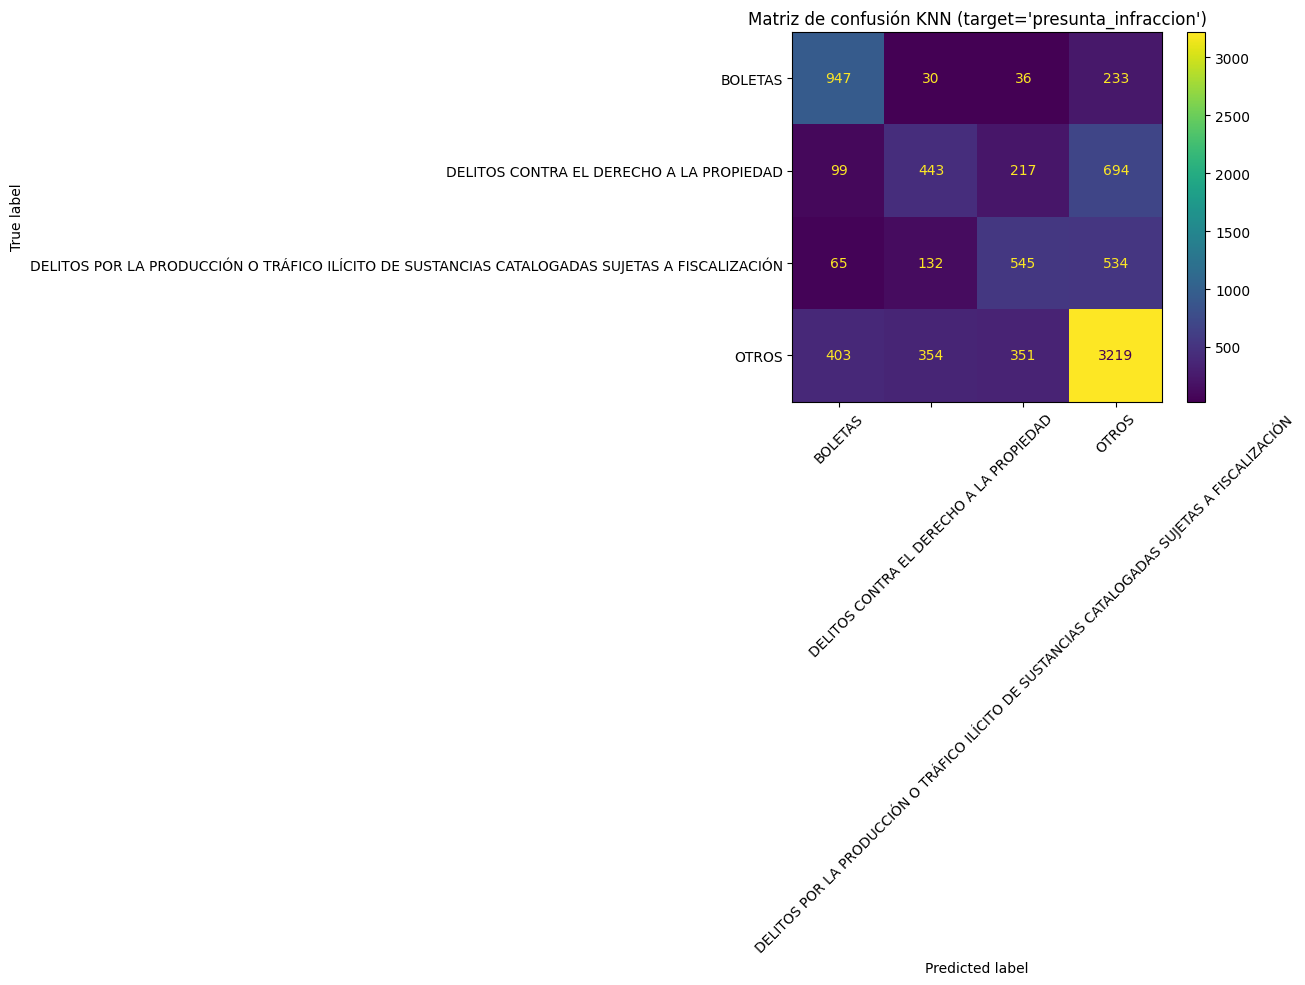

In [15]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== Classification Report (test) ===")
print(classification_report(y_test, y_pred, digits=4))

labels = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.title(f"Matriz de confusión KNN (target='{TARGET_COL}')")
plt.tight_layout()
plt.show()